# Solve Navier-Stokes equation with fully implicit Crank-Nicolson timestepping

In [19]:
%pylab inline
import scipy

from pyiga import bspline, assemble, geometry, vis, solvers

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


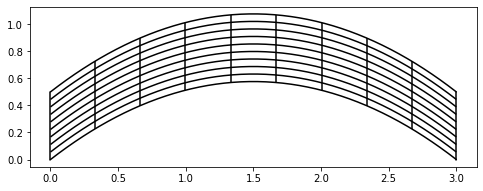

In [20]:
# set up the geometry map
geo = geometry.circular_arc(pi / 8).rotate_2d(pi/2 - pi/16).scale([-1,1])
geo = geo.translate(-geo(0))
geo = geo.scale([3 / geo(1)[0], 30])
geo = geometry.outer_sum(geometry.line_segment([0,0], [0,0.5]), geo)

figsize(8,8)
vis.plot_geo(geo)
axis('scaled');

In [21]:
# define geometry
#geo = geometry.unit_square().scale([3,1])

# define isogeometric discretization space (Taylor-Hood like)
p = 2     # spline degree of velocity space
n_el = (3, 12)   # number of elements in y/x direction

kvs_u = tuple(bspline.make_knots(p,   0.0, 1.0, n, mult=1) for n in n_el)
kvs_p = tuple(bspline.make_knots(p-1, 0.0, 1.0, n, mult=1) for n in n_el)

m_u = tuple(kv.numdofs for kv in kvs_u)
m_p = tuple(kv.numdofs for kv in kvs_p)
n_u1 = prod(m_u)
n_u = 2 * n_u1
n_p = prod(m_p)

In [22]:
def get_components(u):
    """Split solution vector into velocity and pressure components."""
    u1 = u[:n_u1].reshape(m_u)
    u2 = u[n_u1:n_u].reshape(m_u)
    U = np.stack((u1,u2), axis=-1)
    prs = u[n_u:].reshape(m_p)
    return bspline.BSplineFunc(kvs_u, U), bspline.BSplineFunc(kvs_p, prs)

def vel_norm(u):
    """Return a function for evaluating the norm of the velocity."""
    vel, pre = get_components(u)
    def f(X, Y):
        V = vel.grid_eval((Y,X))
        return norm(V, axis=-1)
    return f

In [23]:
# Dirichlet boundary conditions
def g_inflow(x, y): return (40*y*(0.5-y)*exp(-100*(y-.25)**2), 0.0)
def g_zero(x, y):   return (0.0, 0.0)

bcs = assemble.compute_dirichlet_bcs(kvs_u, geo,
    [ ('bottom', g_zero), ('top', g_zero), ('left', g_inflow) ]                                     
)

In [24]:
# Reynolds number
Re = 1e4

# time step
tau = 2e-2

In [25]:
# assemble Stokes problem
A_grad = assemble.assemble('inner(grad(u), grad(v)) * dx', kvs_u, bfuns=[('u',2), ('v',2)], geo=geo)
A_div  = assemble.assemble('div(u) * p * dx', (kvs_u, kvs_p), bfuns=[('u',2,0), ('p',1,1)], geo=geo)
M_pre = assemble.mass(kvs_p, geo)
M_vel = assemble.mass(kvs_u, geo)

M_vel_full = scipy.sparse.bmat(
    [[M_vel, None, None  ],
     [None, M_vel, None  ],
     [None, None, scipy.sparse.csr_matrix((n_p,n_p))]], format='csr')

A_stokes = scipy.sparse.bmat(
    [[Re**-1*A_grad, A_div.T],
     [A_div,     1e-10*M_pre]], format='csr')

In [26]:
# compute initial value from Stokes equation
LS = assemble.RestrictedLinearSystem(A_stokes, 0.0, bcs)
u = LS.complete(solvers.make_solver(LS.A).dot(LS.b))
solutions = [LS.restrict(u)]

In [27]:
# set up nonlinear and linearized N-S system
vel, pre = get_components(u)

#Update does not work currently, so the objects asm_nlconv and asm_linconv are useless

# nonlinear convection term (functional)
#asm_nlconv = assemble.Assembler('grad(vel).dot(vel).dot(v) * dx', kvs_u,
#                    bfuns=[('v',2)], geo=geo, vel=vel, updatable=['vel'])
# linearized convection term by freezing velocity (matrix)
#asm_linconv = assemble.Assembler('grad(u).dot(vel).dot(v) * dx', kvs_u,
#                    bfuns=[('u',2), ('v',2)], geo=geo, vel=vel, updatable=['vel'])

def apply_nl_conv(vel):
    #Update does not work currently:
    # z = asm_nlconv.assemble(vel=vel)
    #Just re-assemble instead:
    z = assemble.assemble('grad(vel).dot(vel).dot(v) * dx', kvs_u,
                    bfuns=[('v',2)], geo=geo, vel=vel)
    #
    return np.concatenate((z.ravel(), np.zeros(n_p)))

def apply_navier_stokes(u_p):
    vel, pre = get_components(u_p)
    return apply_nl_conv(vel) + A_stokes.dot(u_p)

def linearized_ns(u_p):
    vel, pre = get_components(u_p)
    #Update does not work currently:
    # A_linconv = asm_linconv.assemble(vel=vel)
    #Just re-assemble instead:
    A_linconv = assemble.assemble('grad(u).dot(vel).dot(v) * dx', kvs_u,
                    bfuns=[('u',2), ('v',2)], geo=geo, vel=vel)
    #
    A_lns = scipy.sparse.bmat(
        [[Re**-1*A_grad + A_linconv, A_div.T],
         [A_div,                 1e-10*M_pre]],
        format='csr')
    return A_lns

In [28]:
# set up DAE for instationary Navier-Stokes
def ns_F(x):
    u_p = LS.complete(x)
    return -LS.restrict(apply_navier_stokes(u_p))
def ns_J(x):
    u_p = LS.complete(x)
    return -LS.restrict_matrix(linearized_ns(u_p))
ns_M = LS.restrict_matrix(M_vel_full)

In [29]:
t_end = 3.0

time_steps = solvers.rowdaind2(ns_M, ns_F, ns_J, solutions[-1], tau, t_end, tol=1e-2, progress=True)
solutions.extend(time_steps[1][1:])


  0%|          | 0/3.0 [00:00<?, ?it/s]
  1%|          | 0.02/3.0 [00:00<00:05,  1.80s/it, tau=0.02]
  3%|▎         | 0.0826630703973875/3.0 [00:00<00:02,  1.20it/s, tau=0.0627]
  6%|▌         | 0.1762440474274215/3.0 [00:00<00:01,  1.75it/s, tau=0.0627]
  6%|▌         | 0.1762440474274215/3.0 [00:00<00:01,  1.75it/s, tau=0.0936]
  9%|▉         | 0.26446501428753577/3.0 [00:00<00:01,  1.75it/s, tau=0.0882]
 12%|█▏        | 0.3531453670042716/3.0 [00:00<00:02,  1.23it/s, tau=0.0882] 
 12%|█▏        | 0.3531453670042716/3.0 [00:00<00:02,  1.23it/s, tau=0.0887]
 15%|█▌        | 0.4516168100761206/3.0 [00:00<00:02,  1.23it/s, tau=0.0985]
 19%|█▊        | 0.5595059472901969/3.0 [00:00<00:01,  1.42it/s, tau=0.0985]
 19%|█▊        | 0.5595059472901969/3.0 [00:00<00:01,  1.42it/s, tau=0.108] 
 22%|██▏       | 0.6480585453028435/3.0 [00:00<00:01,  1.42it/s, tau=0.0886]
 24%|██▍       | 0.724122864887873/3.0 [00:00<00:01,  1.19it/s, tau=0.0886] 
 24%|██▍       | 0.724122864887873/3.0 [00:00<00:

 96%|█████████▌| 2.8679642937086722/3.0 [00:04<00:00,  2.53s/it, tau=0.0189]
 96%|█████████▌| 2.8874646695544324/3.0 [00:04<00:00,  3.07s/it, tau=0.0189]
 96%|█████████▌| 2.8874646695544324/3.0 [00:04<00:00,  3.07s/it, tau=0.0195]
 97%|█████████▋| 2.909255413950922/3.0 [00:04<00:00,  3.07s/it, tau=0.0218] 
 98%|█████████▊| 2.9326279612064026/3.0 [00:04<00:00,  3.07s/it, tau=0.0234]
 99%|█████████▊| 2.9558600150037835/3.0 [00:04<00:00,  2.66s/it, tau=0.0234]
 99%|█████████▊| 2.9558600150037835/3.0 [00:04<00:00,  2.66s/it, tau=0.0232]
 99%|█████████▉| 2.97745656633375/3.0 [00:04<00:00,  2.66s/it, tau=0.0216]  
100%|██████████| 3.002112307581682/3.0 [00:04<00:00,  1.42s/it, tau=0.0247]


[0.         0.02       0.08266307 0.17624405 0.26446501 0.35314537
 0.45161681 0.55950595 0.64805855 0.72412286 0.79893863 0.87140363
 0.9417943  1.01037989 1.07263181 1.13271905 1.18173512 1.22963661
 1.27866916 1.32829069 1.36983169 1.4106114  1.45081125 1.49153536
 1.53131977 1.56884155 1.60411652 1.63992544 1.67749646 1.7165854
 1.75487503 1.79032995 1.82325727 1.85368211 1.88410793 1.91444983
 1.94523682 1.97594938 2.00586794 2.03546837 2.06553328 2.09537794
 2.12419683 2.15372497 2.1875445  2.22668882 2.26886181 2.30092737
 2.32741645 2.34952079 2.36826989 2.38648028 2.40308909 2.41838706
 2.43251177 2.44583145 2.45890884 2.47177822 2.48429771 2.49627636
 2.50848601 2.52168798 2.53716399 2.55614515 2.58102289 2.60941203
 2.63774373 2.66270442 2.68421554 2.69973957 2.71390457 2.73229936
 2.75425587 2.77805724 2.79630191 2.81374862 2.83107818 2.8490741
 2.86796429 2.88746467 2.90925541 2.93262796 2.95586002 2.97745657
 3.00211231]


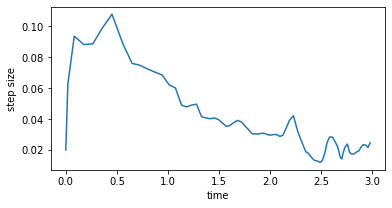

In [30]:
# plot history of step sizes
figsize(6,3)
times = array(time_steps[0])
print(times)
stepsizes = times[1:] - times[:-1]
#print(times[1:])
#print(times[:-1])
#print(stepsizes)
plot(times[:-1], stepsizes);
xlabel('time'); ylabel('step size');

In [15]:
T_anim = linspace(0, 3, 200)   # animation timesteps
# interpolate adaptive solution at the animation frame times
sol_interp = scipy.interpolate.interp1d(time_steps[0],
                [LS.complete(uu) for uu in time_steps[1]], axis=0)
fields = [vel_norm(sol_interp(tt)) for tt in T_anim]

  0%|          | 0/200 [00:00<?, ?it/s]

RuntimeError: Requested MovieWriter (ffmpeg) not available

  0%|          | 1/200 [00:00<02:40,  1.24it/s]

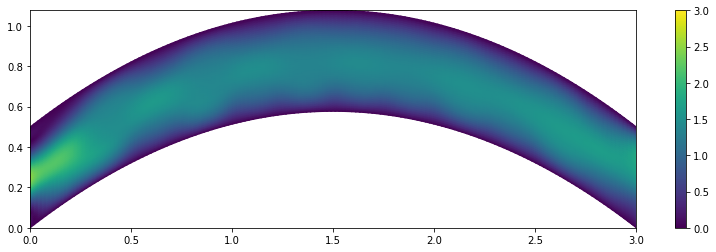

In [16]:
from IPython.display import HTML

figsize(14, 4)
#fields = [vel_norm(LS.complete(uu)) for uu in solutions]
HTML(vis.animate_field(fields, geo, res=(50, 150), vrange=(0,3), interval=35, progress=True).to_html5_video())

In [17]:
xgrid = linspace(0, 1, 200)
xygrid = (xgrid, xgrid)

velocity, pressure = get_components(LS.complete(solutions[-1]))

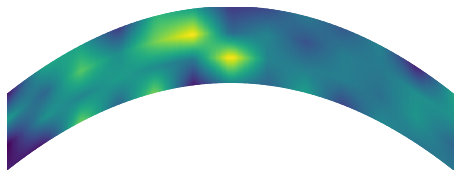

In [18]:
figsize(8,3)
axis('off')
vis.plot_field(pressure, geo);